In [91]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy

from actsnfink import *
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
import pickle
import glob
import matplotlib.pylab as plt
import joblib

In [20]:

taxonomy = {111: 'Ia',
           112: 'Ibc',
           113: 'II',
           114: 'Iax',
           115: '91bg',
           120: 'FastOther',
           121: 'KN',
           122: 'Mdwarf',
           123: 'DwarfNovae',
           124: 'mLens',
           130: 'LongOther',
           131: 'SLSN',
           132: 'TDE',
           133: 'ILOT',
           134: 'CART',
           135: 'PISN',
           210: 'PeriodicOther',
           211: 'Cepheid',
           212: 'RRLyrae',
           213: 'dScuti',
           214: 'EB',
           215: 'LPVMira',
           220: 'NonPeriodicOther',
           221: 'AGN'}

# create inverse taxonomy
taxonomy_inv = {v: k for k, v in taxonomy.items()}


In [2]:
input_dir = '/media/ELAsTICC/Fink/first_year/early_SNIa/all_features/'

flist = os.listdir(input_dir)
flist.remove('.ipynb_checkpoints')

data_list = []
for fname in flist:
    data_temp = pd.read_csv(input_dir + fname, index_col=False)
    
    col_remove = []
    for colname in data_temp.keys():
        if 'Unnamed' in colname:
            col_remove.append(colname)
            
    if len(col_remove) > 0:
        data_temp.drop(columns=col_remove, inplace=True)

    data_list.append(data_temp)
    
    print(fname, len(data_temp.keys()), data_temp.shape[0], np.unique(data_temp['classId'].values))
    
data_pd = pd.concat(data_list, ignore_index=True)

print('Total: ', data_pd.shape[0])

class_111.csv 48 2507323 [111]
class_131.csv 48 170026 [131]
class_212.csv 48 2230557 [212]
class_214.csv 48 1301841 [214]
class_124.csv 48 12923 [124]
class_123.csv 48 4023 [123]
class_135.csv 48 2761 [135]
class_213.csv 48 429117 [213]
class_221.csv 48 453542 [221]
class_113.csv 48 2451398 [113]
class_115.csv 48 49795 [115]
class_133.csv 48 4043 [133]
class_132.csv 48 30705 [132]
class_121.csv 48 5 [121]
class_134.csv 48 12833 [134]
class_211.csv 48 47713 [211]
class_112.csv 48 583007 [112]
class_114.csv 48 60497 [114]
Total:  10352109


In [4]:
data_pd.keys()

Index(['diaObjectId', 'alertId', 'classId', 'hostgal_dec', 'hostgal_ra',
       'hostgal_snsep', 'hostgal_zphot', 'hostgal_zphot_err', 'mwebv_err',
       'mwebv_err.1', 'ra', 'decl', 'a_u', 'b_u', 'c_u', 'snratio_u', 'mse_u',
       'nrise_u', 'a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g', 'nrise_g', 'a_r',
       'b_r', 'c_r', 'snratio_r', 'mse_r', 'nrise_r', 'a_i', 'b_i', 'c_i',
       'snratio_i', 'mse_i', 'nrise_i', 'a_z', 'b_z', 'c_z', 'snratio_z',
       'mse_z', 'nrise_z', 'a_Y', 'b_Y', 'c_Y', 'snratio_Y', 'mse_Y',
       'nrise_Y'],
      dtype='object')

In [36]:
# read training samples
flist = glob.glob('/media/ELAsTICC/Fink/first_year/early_SNIa/AL/UncSampling/training_samples/train_*.csv')

train_list = []
for fname in flist:
    train_list.append(pd.read_csv(fname, index_col=False))
    
train_pd = pd.concat(train_list, ignore_index=True)
train_pd.drop(columns=['Unnamed: 0'], inplace=True)
train_pd = train_pd.sample(n=train_pd.shape[0], replace=False)

train_pd.drop_duplicates(subset=['id'], keep='first', inplace=True)
train_pd.drop(columns=['mwebv_err', 'mwebv_err.1'], inplace=True)

In [37]:
if np.unique(train_pd['id'].values).shape[0] != train_pd.shape[0]:
    raise ValueError('Repeated ids in training.')

In [38]:
train_pd.shape

(190268, 47)

In [39]:
train_pd.keys()

Index(['diaObjectId', 'id', 'classId', 'type', 'hostgal_dec', 'hostgal_ra',
       'hostgal_snsep', 'hostgal_zphot', 'hostgal_zphot_err', 'ra', 'decl',
       'a_u', 'b_u', 'c_u', 'snratio_u', 'mse_u', 'nrise_u', 'a_g', 'b_g',
       'c_g', 'snratio_g', 'mse_g', 'nrise_g', 'a_r', 'b_r', 'c_r',
       'snratio_r', 'mse_r', 'nrise_r', 'a_i', 'b_i', 'c_i', 'snratio_i',
       'mse_i', 'nrise_i', 'a_z', 'b_z', 'c_z', 'snratio_z', 'mse_z',
       'nrise_z', 'a_Y', 'b_Y', 'c_Y', 'snratio_Y', 'mse_Y', 'nrise_Y'],
      dtype='object')

In [23]:
# check labels in training
snclass, freq = np.unique(train_pd['classId'].values, return_counts=True)

for i in range(len(snclass)):
    print(taxonomy[snclass[i]], '--', round(freq[i]/train_pd.shape[0],3))

Ia -- 0.404
Ibc -- 0.052
II -- 0.057
Iax -- 0.043
91bg -- 0.04
DwarfNovae -- 0.0
mLens -- 0.0
SLSN -- 0.05
TDE -- 0.018
ILOT -- 0.002
CART -- 0.009
PISN -- 0.001
Cepheid -- 0.001
RRLyrae -- 0.086
dScuti -- 0.089
EB -- 0.091
AGN -- 0.055


In [31]:
# remove training from the rest of the data
flag_train_alert = np.isin(data_pd['diaObjectId'].values, train_pd['diaObjectId'].values)
data_use = data_pd[~flag_train_alert]

In [32]:
data_use.shape

(7978549, 48)

In [ ]:
train_pd.shape

In [40]:
features_names_rep = list(data_pd.keys())
for name in ['diaObjectId', 'alertId', 'mwebv_err', 'mwebv_err.1']:
    features_names_rep.remove(name)
    
features_names_rep

['classId',
 'hostgal_dec',
 'hostgal_ra',
 'hostgal_snsep',
 'hostgal_zphot',
 'hostgal_zphot_err',
 'ra',
 'decl',
 'a_u',
 'b_u',
 'c_u',
 'snratio_u',
 'mse_u',
 'nrise_u',
 'a_g',
 'b_g',
 'c_g',
 'snratio_g',
 'mse_g',
 'nrise_g',
 'a_r',
 'b_r',
 'c_r',
 'snratio_r',
 'mse_r',
 'nrise_r',
 'a_i',
 'b_i',
 'c_i',
 'snratio_i',
 'mse_i',
 'nrise_i',
 'a_z',
 'b_z',
 'c_z',
 'snratio_z',
 'mse_z',
 'nrise_z',
 'a_Y',
 'b_Y',
 'c_Y',
 'snratio_Y',
 'mse_Y',
 'nrise_Y']

In [34]:
data_use.drop(columns=['mwebv_err', 'mwebv_err.1'], inplace=True)

In [46]:
data_train_features = deepcopy(train_pd[features_names_rep[1:]])
data_train_labels = train_pd['classId'].values == 111

data_test_features = deepcopy(data_use[features_names_rep[1:]])
#data_test_features = deepcopy(data_test_use[features_use])

data_test_labels = data_use['classId'].values == 111

In [42]:
train_pd.to_csv('/media/ELAsTICC/Fink/first_year/early_SNIa/AL/UncSampling/final_model/train.csv', 
                      index=False)

In [43]:
data_use.to_csv('/media/ELAsTICC/Fink/first_year/early_SNIa/AL/UncSampling/final_model/test.csv',
                       index=False)

In [44]:
data_use.shape

(7978549, 46)

In [93]:
nest = 100
seed = 42
max_depth = 30
n_jobs = 30
min_samples_leaf=0.0001

clf = RandomForestClassifier(n_estimators=nest, random_state=seed,
                             max_depth=max_depth, n_jobs=n_jobs,
                             min_samples_leaf= min_samples_leaf)
clf.fit(data_train_features, data_train_labels)

RandomForestClassifier(max_depth=50, min_samples_leaf=0.0001, n_jobs=30,
                       random_state=42)

In [94]:
pred = clf.predict(data_test_features)
probIa = clf.predict_proba(data_test_features[data_test_labels == 1])
probnIa = clf.predict_proba(data_test_features[data_test_labels == 0])
prob = clf.predict_proba(data_test_features)

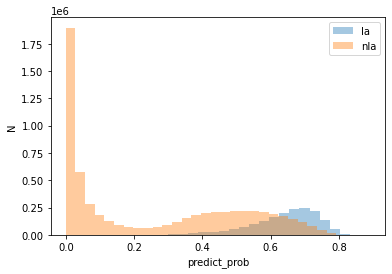

In [95]:
plt.figure()
plt.hist(probIa[:,1], label='Ia', alpha=0.4, bins=30)
plt.hist(probnIa[:,1], label='nIa', alpha=0.4, bins=30)
plt.legend()
plt.xlabel('predict_prob')
plt.ylabel('N')
plt.show()

In [82]:
data_test_features.shape

(7978549, 43)

In [83]:
sum(data_test_labels)

1754259

In [84]:
clf.score(data_train_features, data_train_labels)

1.0

In [96]:
clf.score(data_test_features, data_test_labels)

0.7915202375770332

In [97]:
sum(data_test_labels[prob[:,1] > 0.5])/sum(prob[:,1] > 0.5)

0.5148137415613028

In [98]:
sum(data_test_labels[prob[:,1] > 0.8])/sum(prob[:,1] > 0.8)

0.8949639317737478

In [99]:
sum(data_test_labels[prob[:,1] > 0.8])/sum(data_test_labels)

0.0075672976453305925

In [100]:
filename = '../data/earlysnia_elasticc_small.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [101]:
# save model
filename = '../data/earlysnia_elasticc_small.joblib'

joblib.dump(clf, filename)

['../data/earlysnia_elasticc_small.joblib']

In [16]:
np.array(features_names_rep[1:])[clf.feature_importances_.argsort()]

array(['nrise_u', 'nrise_g', 'mse_u', 'a_u', 'b_u', 'mse_g', 'nrise_Y',
       'a_g', 'b_g', 'nrise_z', 'c_u', 'mse_Y', 'nrise_r', 'c_g',
       'snratio_u', 'a_Y', 'b_Y', 'mse_z', 'snratio_g', 'nrise_i', 'c_Y',
       'a_z', 'c_z', 'b_z', 'mse_r', 'decl', 'ra', 'snratio_z', 'mse_i',
       'snratio_i', 'snratio_r', 'b_r', 'snratio_Y', 'a_i', 'c_i', 'a_r',
       'c_r', 'b_i', 'hostgal_dec', 'hostgal_snsep', 'hostgal_ra',
       'hostgal_zphot_err', 'hostgal_zphot'], dtype='<U17')

### Crossvalidate

In [18]:
scoring = ['precision_macro', 'recall_macro']

In [20]:
nest = 30
max_depth = 30
n_jobs = 20
cv=10

clf = RandomForestClassifier(n_estimators=nest, random_state=seed,
                             max_depth=max_depth)
scores = cross_validate(clf, data_train_use[list(data_train_use.keys())[3:]], 
                        data_train_use['classId'].values == 111, scoring=scoring,
                       return_train_score=True, cv=cv)

In [21]:
scores['test_precision_macro']

array([0.85566007, 0.85508283, 0.85397706, 0.85309592, 0.85130072,
       0.85452727, 0.85328974, 0.85552044, 0.85523075, 0.8555537 ])

In [22]:
scores['train_precision_macro']

array([0.97005914, 0.96994843, 0.97106427, 0.97168394, 0.97099679,
       0.9689634 , 0.97081157, 0.97067437, 0.96986394, 0.9707479 ])